GAN exercise:

The goal of this exercise is to create a DCGAN to generate Manga faces





In [ ]:
#!pip3 install torch torchvision
import torch

Check gpu type

In [ ]:
!nvidia-smi

Tue Feb  9 15:43:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# download dataset
!git clone https://gitlab.inria.fr/yaowang/gan_class_images.git

Cloning into 'gan_class_images'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.


In [ ]:
!ls

gan_class_images  sample_data


In [ ]:
!cd gan_class_images;unzip -q images.zip

Display the first image in training set

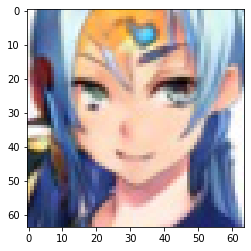

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
img = plt.imread('gan_class_images/images/3.jpg')
plt.imshow(img)
plt.show()

In [ ]:
import torch
import torchvision
import torch.nn as nn
from PIL import Image
import os
import torchvision.transforms as transforms
import torch.optim as optim
import random
import glob
from torch.utils.data import Dataset
from torchvision.utils import make_grid
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from IPython import display
import time

Define custom dataset

In [ ]:
class MangaFace(Dataset):
    def __init__(self, root, transform=None):
        """Initialize Pokemon."""
        self.transform = transform
        self.root = root
        self.imgs = glob.glob(self.root + '*')

    def __getitem__(self, idx):
        """Get item from Pokemon class.
        Args:
            index (int): Index
        Returns:
            img: PIL Image.
        """
        img = self.imgs[idx]
        img = Image.open(img).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img

    def __len__(self):
        """Get length."""
        return len(self.imgs)

train_transform = transforms.Compose([
                                      transforms.Resize((64,64)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = MangaFace(root='./gan_class_images/images/', transform=train_transform)
print(len(trainset))

36740


Network weights initialization

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

Define Generator network

In [ ]:
'''
input size: batchsize * 100 * 1 * 1
output size: batchsize * 3 * 64 * 64

hint: use nn.ConvTranspose2d to upsample spatial dimension

* 1st layer:
transposed convolution
batch norm
relu

* 2nd layer
transposed convolution
batch norm
relu

* 3rd layer
transposed convolution
batch norm
relu

* 4th layer
transposed convolution
batch norm
relu

* 5th layer
transposed convolution
tanh
'''

import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # TODO:

        self.net = nn.Sequential(
        # 1st layer output: bs * 512 * 4 * 4

        # 2nd layer output: bs * 256 * 8 * 8

        # 3rd layer output: bs * 128 * 16 * 16

        # 4th layer output: bs * 64 * 32 * 32

        # 5th layer output: bs * 3 * 64 * 64

        )
    def forward(self, x):

        out = self.net(x)

        return out

In [ ]:
# test Generator
z = torch.randn(8, 100, 1, 1)
net = Generator()
out = net(z) # 8 * 3 * 64 * 64
print(out.size())

torch.Size([8, 3, 64, 64])


In [ ]:
'''
input size: batchsize * 3 * 64 * 64
output size: batchsize * 1

* 1st layer:
convolution
relu

* 2nd layer
convolution
batch norm
relu

* 3rd layer
convolution
batch norm
relu

* 4th layer
convolution
batch norm
relu

* 5th layer
convolution
sigmoid

'''

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
        # 1st layer output: bs * 64 * 32 * 32

        # 2nd layer output: bs * 128 * 16 * 16

        # 3rd layer output: bs * 256 * 8 * 8

        # 4th layer output: bs * 512 * 4 * 4

        # 5th layer output: bs * 1

        )
    def forward(self, x):

        out = self.net(x)

        return out.squeeze(-1).squeeze(-1)

In [ ]:
x = torch.randn(4, 3, 64, 64)
net = Discriminator()
out = net(x)
print(out.size()) # 4 * 1

torch.Size([4, 1])


Display function

In [ ]:
def display_demos(fixed_noise, epoch, iters):
  img_list = []
  with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
    plt.rcParams["figure.figsize"]=10,10
    plt.clf()
    plt.title('epoch: %d iteration: %d'%(epoch, iters))
    imgs = make_grid(fake.data*0.5+0.5).cpu() # CHW
    plt.imshow(imgs.permute(1,2,0).numpy())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(1.0)

Main

In [ ]:
# define parameters
batch_size = 128 # 64, 32
beta1 = 0.5 # optimization function
lr = 2e-4 # learning rate
nz = 100 # input dimension
num_epochs = 100 # trainings
num_workers = 8 #

# set device
device = torch.device("cuda:0")

# load dataset
train_transform = transforms.Compose([
                                        transforms.Resize((64,64)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = MangaFace(root='./gan_class_images/images/', transform=train_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

# define G, D and initialize parameters
# attention: put it into GPU


# define loss function
# hint: binary cross entropy

# Create batch of latent vectors (64 * nz * 1 * 1) that we will use to visualize
# hint: torch.randn

# Setup Adam optimizers for both G and D


#img_list for loss
G_losses = []
D_losses = []
iters = 0

print("==> start training")
for epoch in range(num_epochs):
  # For each batch in the dataloader
  for i, data in enumerate(dataloader):
    ############################
    # Update D network
    # maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    # put data into gpu


    ## Train with all-real batches
    # set D gradient 0


    # Forward pass real batch through D


    # set ground truth label 1


    # Calculate loss on all-real batch


    # Calculate gradients for D in backward pass


    ## Train with all-fake batch
    # Generate batch of latent vectors


    # Generate fake image batch with G


    # Classify all fake batch with D


    # set ground truth label 0


    # Calculate D's loss on the all-fake batch


    # Calculate the gradients for this batch


    # Add the gradients from the all-real and all-fake batches


    # Update D


    ############################
    # Update G network
    # maximize log(D(G(z)))
    ###########################
    # set G gradient 0

    # Since we just updated D, perform another forward pass of all-fake batch through D


    # Calculate G's loss based on this output

    # Calculate gradients for G

    # Update G


    # Save Losses for plotting later


    # display demo images each 50 iterations
    if iters % 50 == 0:
      display_demos(fixed_noise, epoch, iters)

    iters += 1

Buffered data was truncated after reaching the output size limit.

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()